## Fit single Model to variogram points

In [19]:
%load_ext autoreload
%autoreload 2

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 - generate 1D variogram and fit a single Gaussian model to it
 - fit multiple Gaussian to 1D model
 - try with higher dimensions

 $\gamma = b + c_0 * (1-e^{-\frac{h^2}{a^2}})$
 where
 $a= \frac{r}{2}$

Note: To use `scipy.optimize.curve_fit()` good initial parameters are important AND data should be standardized

parameters: [20.49180617  1.62734152 -0.70380295]


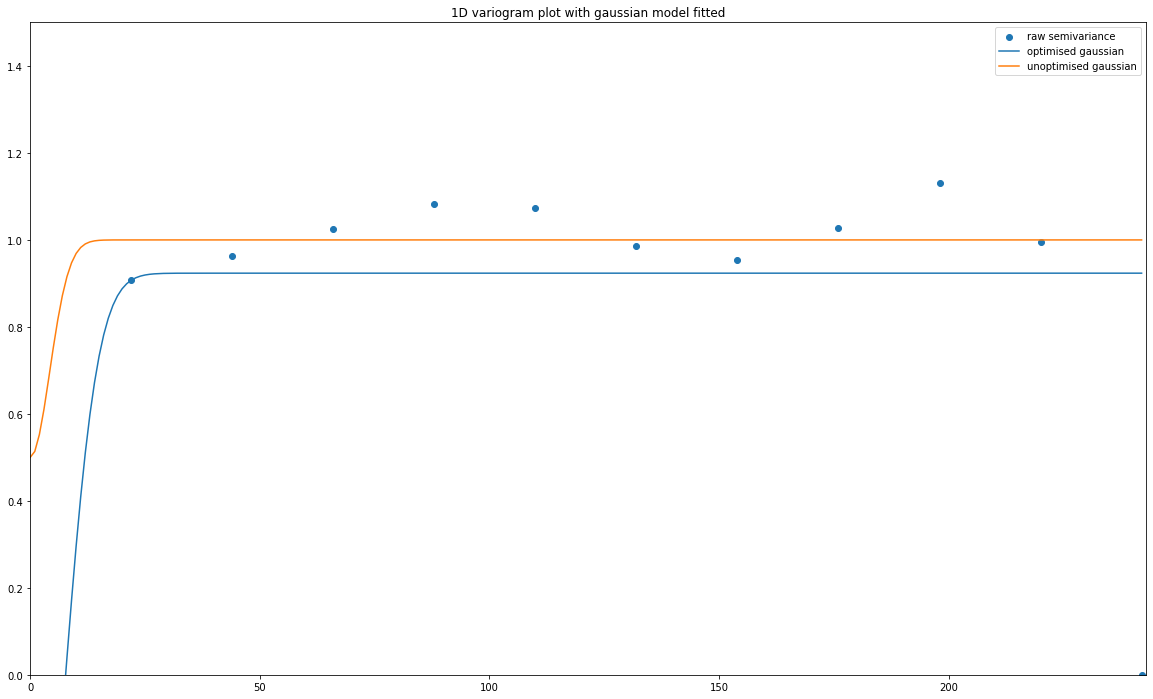

In [26]:
# define gaussian func which returns gamma
def gaussian(h, r, c0, b=0):
    """returns semivariance"""
    a = r / 2
    return b + c0 * (1. - np.exp(- (h ** 2 / a ** 2)))

def spherical(h, r, c0, b=0):
    a = r / 1.
    if hasattr(h, "__iter__"):
        output = np.empty(len(h))
        for i in range(len(output)):     
            if h[i] <= r:
                output[i] = b + c0 * ((1.5 * (h[i] / a)) - (0.5 * ((h[i] / a) ** 3.0)))
            else:
                output[i] = b + c0  
        return output 
    else:
        if h <= r:
            return b + c0 * ((1.5 * (h / a)) - (0.5 * ((h / a) ** 3.0)))
        else:
            return b + c0     

def exponential(h, r, c0, b=0):
    a = r / 3.
    return b + c0 * (1. - np.exp(-(h / a)))

def visualise_fit(func, resolution, *params):
    # inference with tuned model
    predictions_optimised = []
    for lag in range(resolution):
        predictions_optimised.append(func(lag, *params))

    # visualise the functions
    fig = plt.figure(figsize=(20,12))
    plt.scatter(data["lag"], data["semivariance"], label="raw semivariance")
    plt.plot(range(resolution), predictions_optimised, label=f"optimised {func.__name__}")
    plt.ylim([0,1.5])
    plt.xlim([0, resolution])
    plt.title(f"1D variogram plot with {func.__name__} model fitted")
    # plt.legend()
    return fig.gca()

# read in data
data = pd.read_csv("/home/jonas/Downloads/variogram_pts.csv")

# predict with tuned model
model = gaussian
resolution = data["lag"].iloc[-1] + 1
popt, pcov = scipy.optimize.curve_fit(model, data["lag"], data["semivariance"], p0=[10,1,0.2])
ax = visualise_fit(model, resolution, *popt)
print(f"parameters: {popt}")

# make some sort of initial guess, one for each hyper-param of gaussian()
params = [12,0.5,0.5]
# predict with untuned model
predictions = []
for lag in range(resolution):
    predictions.append(model(lag, params[0], params[1], params[2]))
ax.plot(range(resolution), predictions, label=f"unoptimised {model.__name__}")
plt.legend()
plt.show()

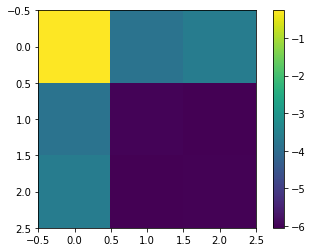

In [3]:
# show the covariance matrix
plt.imshow(np.log(np.abs(pcov)))
plt.colorbar()
plt.show()

In [ ]:
# compute metrics to evaluate fit
print(f"R^2: {r2_score(data['semivariance'], predictions_optimised[4::10])}")
print(f"mean squared error: {mean_squared_error(data['semivariance'], predictions_optimised[4::10])}")

## Fit multiple stacked models

In [ ]:
def stacked_gaussian(h, r1, r2, c01, c02, b1, b2):
    val1 = gaussian(h, r1, c01, b1)
    val2 = gaussian(h, r2, c02, b2)
    return val1 + val2

def plot_fitted_function(func, *params):
    predictions = []
    for lag in range(resolution):
        predictions.append(func(lag, *params))

    # visualise the functions
    fig = plt.figure(figsize=(20,12))
    plt.scatter(data["lag"], data["semivariance"], label="original")
    plt.plot(range(resolution), predictions, label="fitted function")
    plt.ylim([0,1.5])
    plt.xlim([0, resolution])
    plt.title("1D variogram pts")
    return fig.gca()
    
params_optimised, _ = scipy.optimize.curve_fit(stacked_gaussian, data["lag"], data["semivariance"])
ax = plot_fitted_function(stacked_gaussian, *params_optimised)

# plot part models
gaussian1 = np.empty(resolution)
gaussian2 = np.empty(resolution)
for i in range(resolution):
    gaussian1[i] = gaussian(i, *params_optimised[np.array([0,2,4])])
    gaussian2[i] = gaussian(i, *params_optimised[np.array([1,3,5])])
gaussian2 += params_optimised[4]
gaussian1 += params_optimised[5]
plt.plot(range(resolution), gaussian1, label="func1")
plt.plot(range(resolution), gaussian2, label="func2")
plt.legend()
plt.show()

model param names: ['r', 'c0', 'b']
independent var ['h']
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 25
    # variables        = 3
    chi-square         = 0.08321422
    reduced chi-square = 0.00378246
    Akaike info crit   = -136.630321
    Bayesian info crit = -132.973694
[[Variables]]
    r:   10.0730649 +/- 0.87030051 (8.64%) (init = 10)
    c0:  0.65069890 +/- 0.04947691 (7.60%) (init = 1)
    b:   0.29038475 +/- 0.04891962 (16.85%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.500)
    C(c0, b) = -0.951
    C(r, b)  = 0.620


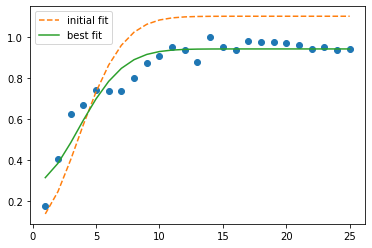

In [6]:
# use lmfit use Model to create multiple models and then stack them such as here:
# https://lmfit.github.io/lmfit-py/examples/documentation/builtinmodels_nistgauss2.html
# CompositeModel: https://lmfit.github.io/lmfit-py/model.html#composite-models-adding-or-multiplying-models

from lmfit.models import Model

# data
y = data["semivariance"]
h = data["lag"]

# define model
model = Model(gaussian)

# setup parameters
params = model.make_params(r=10,c0=1,b=0.1)
print(f"model param names: {model.param_names}")
print(f"independent var {model.independent_vars}")
result = model.fit(y, params, h=h)
print(result.fit_report(min_correl=0.5))

# plot results
plt.plot(h, y, 'o')
plt.plot(h, result.init_fit, '--', label='initial fit')
plt.plot(h, result.best_fit, '-', label='best fit')
plt.legend()
plt.show()

## Fit 3D Variogram Functions

https://stackoverflow.com/questions/28372597/python-curve-fit-with-multiple-independent-variables

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import Model
import lmfit
from typing import List

# read in 3D variogram data
file_path = "/home/jonas/Downloads/big_variogram.csv"
variogram_3d = pd.read_csv(file_path)

# remove zero points where there was no data
variogram_3d = variogram_3d[variogram_3d["u_semivariance"] != 0]
variogram_3d

,lon_lag,lat_lag,time_lag,u_semivariance,v_semivariance
0,40,40,6,0.134356,0.137539
1,40,40,12,0.283739,0.268588
2,40,40,18,0.313736,0.296133
3,40,40,24,0.288869,0.289733
4,40,40,30,0.274267,0.280297
...,...,...,...,...,...
311037,2040,720,204,0.613380,0.346873
311038,2040,720,210,0.474249,0.231192
311039,2040,720,216,0.369415,0.127619
311040,2040,720,222,0.294750,0.098865


The 3D Gaussian variogram function has the following form:

$\gamma = s(1 - e^{-3h^{\top} \Omega h})$

where $\Omega$ is a diagonal matrix with diagonal terms $= [\frac{1}{{r_{lon}}^2}, \frac{1}{{r_{lat}}^2}, \frac{1}{{r_{time}}^2}]$

In [3]:
# Define a multi-dimensional Gaussian function (3D)
def exp_normalize(x):
    """More numerically stable exponential function."""
    b = x.max()
    y = np.exp(x-b)
    return y / y.sum()

def multi_dim_gaussian(lag_vec, r_lon, r_lat, r_t, s):
    """3D gaussian as defined in Bradley's pre-print."""
    h = lag_vec
    Omega = np.diag([1/(r_lon)**2, 1/(r_lat)**2, 1/(r_t)**2])
    h_Omega = np.dot(h, Omega)
    # row-wise dot product of two matrices
    # https://stackoverflow.com/questions/15616742/vectorized-way-of-calculating-row-wise-dot-product-two-matrices-with-scipy
    exponent = np.sum(h_Omega*h, axis=1)
    gamma = s*(1 - exp_normalize(-3*exponent))
    return gamma

def multi_dim_gaussian_slice(lag, r, s):
    """1D version of multi_dim_gaussian for visualizing slices."""
    gamma = s*(1-np.exp(-3*(1/r**2)*lag**2))
    return gamma


# predict with tuned model
model = multi_dim_gaussian
lags = np.hstack((variogram_3d["lon_lag"].to_numpy().reshape(-1,1),
                variogram_3d["lat_lag"].to_numpy().reshape(-1,1),
                variogram_3d["time_lag"].to_numpy().reshape(-1,1)))
                
range_lim = [-2000, 2000]
popt, pcov = scipy.optimize.curve_fit(model, lags, variogram_3d["u_semivariance"], p0=[-40,-20,-40,1.0],\
    bounds=([range_lim[0], range_lim[0], range_lim[0], -5],[range_lim[1], range_lim[1], range_lim[1], 5]))

print(f"parameters: {popt}")


parameters: [  6.95886477 -17.85533735 -73.86671915   1.3170103 ]


   lon_lag  lat_lag  time_lag  u_semivariance  v_semivariance
0       40       40         6        0.134356        0.137539
1       40       40        12        0.283739        0.268588
2       40       40        18        0.313736        0.296133
3       40       40        24        0.288869        0.289733
4       40       40        30        0.274267        0.280297


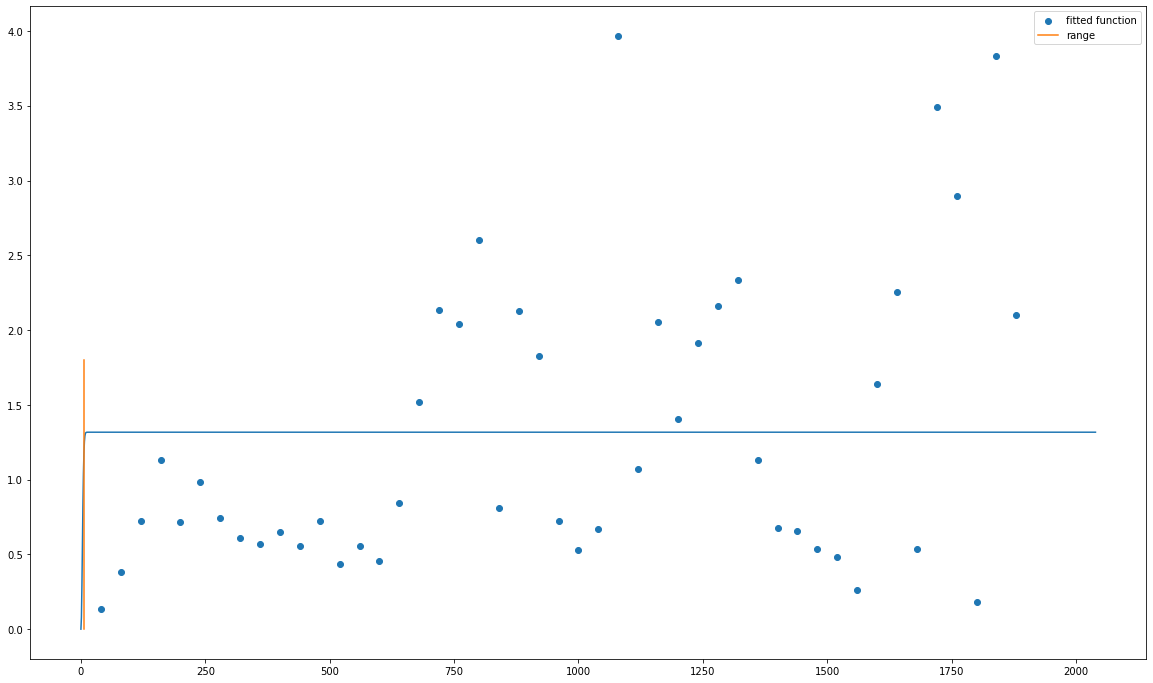

In [4]:
# create slice in var of fitted function
var = "lon_lag"
range_param_map = {"lon_lag":0, "lat_lag":1, "time_lag":2}
var_semivariance = []
var_lags = sorted(list(set(variogram_3d[var])))
var_lags = range(var_lags[-1])
for lag in var_lags:
    var_semivariance.append(multi_dim_gaussian_slice(lag, popt[range_param_map[var]], popt[-1]))

# slice variogram data
print(variogram_3d[:5])
index_to_remove = range_param_map[var]
res = [40,40,6]
vars = ["lon_lag", "lat_lag", "time_lag"]
del vars[index_to_remove]
del res[index_to_remove]
var_slice = variogram_3d[(variogram_3d[vars[0]] == res[0]) & (variogram_3d[vars[1]] == res[1])]
var_lags_variogram = var_slice[var]
var_semivariance_variogram = var_slice["u_semivariance"]

# visualize slices
fig = plt.figure(figsize=(20,12))
plt.plot(var_lags, var_semivariance)
plt.scatter(var_lags_variogram, var_semivariance_variogram, label="fitted function")
plt.plot(np.full(10,abs(popt[range_param_map[var]])), np.arange(0,2,0.2), label="range")
plt.legend()

## Fit Multiple Stacked 3D Variogram Functions

In [45]:
def _get_pts_from_fitted_function(var_lags: List[float], popt: List[float], var: str="lon_lag"):
    semivariance = []
    for lag in var_lags:
        semivariance.append(multi_dim_gaussian_slice(lag, popt[range_param_map[var]], popt[-1]))
    return semivariance


def visualize_sliced_variogram(variogram: pd.DataFrame, popt: List[float], var: str="lon_lag"):
    range_param_map = {"lon_lag":0, "lat_lag":1, "time_lag":2}
    var_lags = range(sorted(list(set(variogram[var])))[-1])

    # add contributions from multiple stacked functions
    var_semivariance = []
    for model in (range(popt.shape[0])):
        if model == 0:
            var_semivariance = np.array(_get_pts_from_fitted_function(var_lags, popt[model], var=var))
        else:
            var_semivariance += np.array(_get_pts_from_fitted_function(var_lags, popt[model], var=var)) 

    # slice variogram data to get empirical points
    index_to_remove = range_param_map[var]
    res = [variogram_3d["lon_lag"].min(),variogram_3d["lat_lag"].min(),variogram_3d["time_lag"].min()]
    vars = list(range_param_map.keys())
    del vars[index_to_remove]
    del res[index_to_remove]
    var_slice = variogram_3d[(variogram_3d[vars[0]] == res[0]) & (variogram_3d[vars[1]] == res[1])]
    var_lags_variogram = var_slice[var]
    var_semivariance_variogram = var_slice["u_semivariance"]

    # visualize slices
    fig = plt.figure(figsize=(20,12))
    plt.plot(var_lags, var_semivariance, label="fitted function")
    plt.scatter(var_lags_variogram, var_semivariance_variogram, label="empirical points")
    # plt.plot(np.full(10,abs(popt[range_param_map[var]])), np.arange(0,2,0.2), label="range")
    plt.legend()
    plt.xlim(left=0)
    plt.ylim([0,2])

def initialise_parameters(model):
    params = lmfit.Parameters()
    weights_list = []
    num_components = len(model.components)
    for i, model in enumerate(model.components):
        params.add(f"{model.prefix}r_lon", value=np.random.rand()*10, max=2000, min=0)
        params.add(f"{model.prefix}r_lat", value=np.random.rand()*10, max=2000, min=0)
        params.add(f"{model.prefix}r_t", value=np.random.rand()*10, max=2000, min=0)
        if i == num_components-1:
            params.add(f"{model.prefix}s", value=np.random.rand(), expr=f"1.0 - {' - '.join(weights_list)}", max=1, min=0)
        else:
            params.add(f"{model.prefix}s", value=np.random.rand(), max=1, min=0)

        weights_list.append(f"{model.prefix}s")
    return params

gauss1 = Model(multi_dim_gaussian, prefix="g1_")
gauss2 = Model(multi_dim_gaussian, prefix="g2_")
gauss3 = Model(multi_dim_gaussian, prefix="g3_")
gauss4 = Model(multi_dim_gaussian, prefix="g4_")
model = gauss1 + gauss2 + gauss3 + gauss4
print(f"Number of models: {len(model.components)}")

params = initialise_parameters(model)
print(params)

result = model.fit(variogram_3d["u_semivariance"], params, lag_vec=lags)
# print(result.fit_report(min_correl=0.5))

popt = np.array(list(result.params.valuesdict().values())).reshape(-1,4)
print(f"Parameters:\n {popt}")

Number of models: 4
Parameters([('g1_r_lon', <Parameter 'g1_r_lon', value=3.888939117795381, bounds=[0:2000]>), ('g1_r_lat', <Parameter 'g1_r_lat', value=5.101434663771275, bounds=[0:2000]>), ('g1_r_t', <Parameter 'g1_r_t', value=3.0869880120794524, bounds=[0:2000]>), ('g1_s', <Parameter 'g1_s', value=0.49798570249294805, bounds=[0:1]>), ('g2_r_lon', <Parameter 'g2_r_lon', value=8.900435592514217, bounds=[0:2000]>), ('g2_r_lat', <Parameter 'g2_r_lat', value=1.4804103612652353, bounds=[0:2000]>), ('g2_r_t', <Parameter 'g2_r_t', value=5.862746624217396, bounds=[0:2000]>), ('g2_s', <Parameter 'g2_s', value=0.8849329887850527, bounds=[0:1]>), ('g3_r_lon', <Parameter 'g3_r_lon', value=9.922006204246832, bounds=[0:2000]>), ('g3_r_lat', <Parameter 'g3_r_lat', value=2.32514502793179, bounds=[0:2000]>), ('g3_r_t', <Parameter 'g3_r_t', value=7.391329874190485, bounds=[0:2000]>), ('g3_s', <Parameter 'g3_s', value=0.08725875070343281, bounds=[0:1]>), ('g4_r_lon', <Parameter 'g4_r_lon', value=0.958

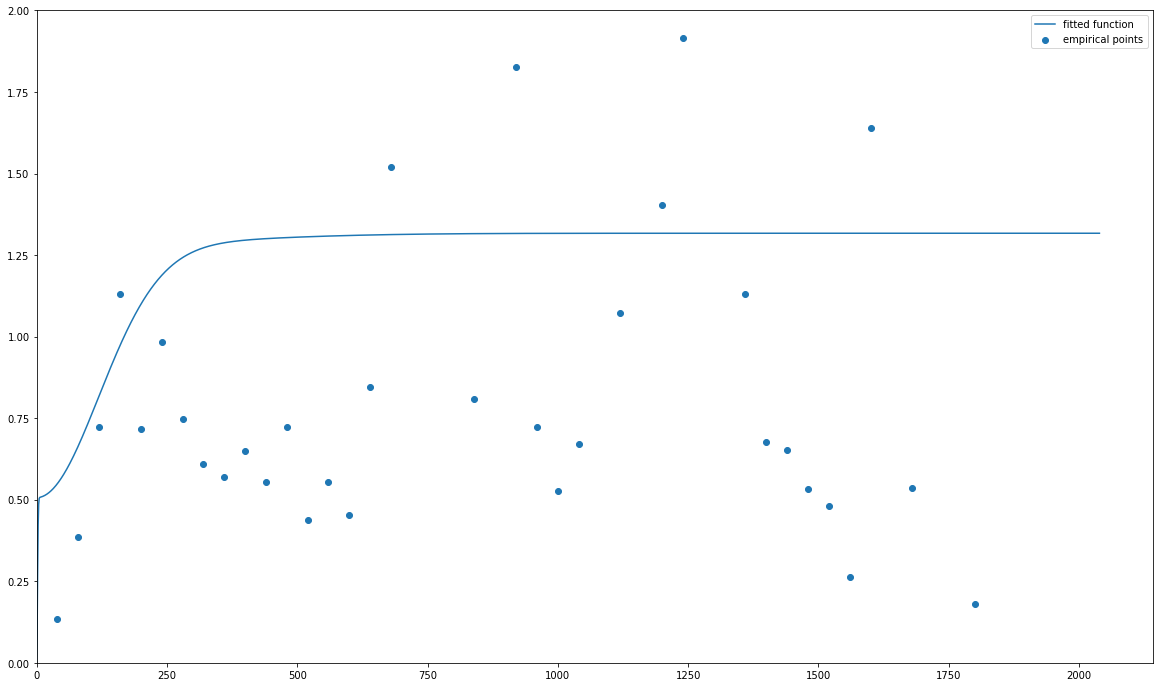

In [49]:
visualize_sliced_variogram(variogram_3d, popt, var="lon_lag")